<a href="https://colab.research.google.com/github/fuadtac/ds-poc/blob/main/re-ds-nlplag2Log-monthly-sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traing a Model for Sales Forecasting of NLP
### Training and Testing with XGBoost ML Model
### Training on Monthly Aggregate Sales for top regular cusotmer


### Installing Libraries

In [1]:
#installing packages
!pip install pyodbc pandas seaborn  matplotlib numpy xgboost scikit-learn

### Importing Libraries

In [2]:
#importing libraries
import pyodbc
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree
import joblib
import os


### Connecting to Database

In [3]:
# Define connection parameters
server = 'rebates-mssql-2019-2-dev.con8g81q8rff.us-east-1.rds.amazonaws.com'  # e.g., 'your-db-name.region.rds.amazonaws.com'
database = 'dev-rebate-merit'

# Get credentials from environment
username = os.getenv("DB_USER_DEV")
password = os.getenv("DB_PASSWORD_DEV")

# override for local testing
#username = '****'
#password = '***'
driver = '{ODBC Driver 17 for SQL Server}'  # Make sure this driver is installed

In [4]:
# check if username and password are retrieved successfully
#print(username,password)

In [5]:
# Create connection string
connection_string = f'''
    DRIVER={driver};
    SERVER={server};
    DATABASE={database};
    UID={username};
    PWD={password};
    Encrypt=no;
    TrustServerCertificate=yes;
    Connection Timeout=30;
'''

try:
    conn = pyodbc.connect(connection_string)
    print("✅ Connection successful!")
except Exception as e:
    print("❌ Connection failed:", e)

❌ Connection failed: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 17 for SQL Server' : file not found (0) (SQLDriverConnect)")


### Retrieving Data form Database

In [6]:
# Defining SQL query
df_sql = pd.DataFrame()
query = '''
		WITH ACCT as (
			SELECT DATEADD(dd,1,EOMONTH([orderdate],-1)) as [month],
				SID.PayeeCustomerAccount,
				SUM(SID.InvAmt) as [sales],
				Count(SID.productcode) as [no_of_products]
			FROM SalesInvoiceDetail SID
			join batch B ON SID.batchid = B.id
				and B.schemeid in (6918,6401)
			Join CustomerMaster CM ON SID.PayeeCustomerAccount = CM.CustomerAccount
				and BatchNo in (15)
				and ((b.BatchTypeId = 1 and MonthlyPaymentApplicable = 1))
				--OR (b.BatchTypeId = 2 and MonthlyPaymentApplicable = 0))
				and SID.salesinvoicetypeid in (1, 12)
				and excluded = 0 and  category = 'Nobivac Vaccines'
			GROUP BY DATEADD(dd,1,EOMONTH([orderdate],-1)), PayeeCustomerAccount
		)
		SELECT [month],
			CM.Name1 AS [customer],
			[sales],
			[no_of_products]
		FROM ACCT
		JOIN customermaster CM
		ON ACCT.PayeeCustomeraccount = CM.CustomerAccount


'''

# Execute and store results in a pandas DataFrame
try:
    df_sql_export = pd.read_sql(query, conn)
    print("✅ Query executed and data loaded into DataFrame.")
    display(df_sql.head())  # Show first few rows
    df_sql_export.to_csv('nlp_sales_monthly.csv', index=False)
    print("✅ Data exported successfully.")
except Exception as e:
    print("❌ Failed to execute query:", e)


❌ Failed to execute query: name 'conn' is not defined


In [7]:
#df_sql_export.tail()


In [8]:
#df_sql.to_csv('df_sql.csv', index=False)

In [9]:
#df_sql_export.info()

### Importing Sales Data from csv file

In [10]:
# @title Importing Sales Data (CSV)
#loading CSV file into df
#df_sql = pd.read_csv('df_sql.csv',header=None,names=['Date','Customer','Sales'])
df_sql = pd.read_csv('nlp_sales_monthly.csv')
#df_sql = pd.read_csv('https://github.com/fuadtac/ds-poc/blob/main/nlp_sales_monthly.csv')
df_sql.head()

,month,customer,sales,no_of_products
0,2024-12-01,JEFFERSON VETERINARY CENTER,3160.75,6
1,2023-03-01,JEFFERSON VETERINARY CENTER,3850.75,7
2,2023-02-01,JEFFERSON VETERINARY CENTER,2113.75,6
3,2023-09-01,JEFFERSON VETERINARY CENTER,3651.50,9
4,2023-11-01,JEFFERSON VETERINARY CENTER,2778.50,5


# 🧭 Descriptive Analysis Steps

In [11]:
# assigning df_sql to df
df = df_sql.copy(deep=True)

## Ecploring Data Structure

In [12]:
# @title Checking Shape of Data
df.shape

(1386, 4)

In [13]:
# @title View column names and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           1386 non-null   object 
 1   customer        1386 non-null   object 
 2   sales           1386 non-null   float64
 3   no_of_products  1386 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 43.4+ KB


In [14]:
# @title Summary Statistics - Numerical Column
df.describe()

,sales,no_of_products
count,1386.000000,1386.000000
mean,22676.181623,14.676046
std,52830.002164,21.701412
min,-13581.750000,1.000000
25%,3258.562500,3.000000
50%,10671.000000,7.000000
75%,24776.187500,15.000000
max,756609.010000,147.000000


In [15]:
# @title Summary Statistics - Categorial Values
df['customer'].value_counts()

,count
customer,
JEFFERSON VETERINARY CENTER,24
PAMLICO ANIMAL HOSPITAL,24
LARRY D. SHAW,24
VETS PETS PA,24
PET MED MOBILE,24
...,...
MISSION BEND ANIMAL CLINIC,2
SRIKANTH PENNIKA,2
SUN VALLEY HOPE ANIMAL HOSPITAL,2


In [16]:
# @title View column names and data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           1386 non-null   object 
 1   customer        1386 non-null   object 
 2   sales           1386 non-null   float64
 3   no_of_products  1386 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 43.4+ KB


## Data Type Conversion

In [17]:
# @title Convert Date field to DateTime Type
# Convert 'month' to datetime
df['month'] = pd.to_datetime(df['month'])
# Convert 'customer' to string (object to string)
df['customer'] = df['customer'].astype('string')
print(df['customer'].dtype)  # Check dtype after conversion
#df.set_index('date', inplace=True)
df.head()

string


,month,customer,sales,no_of_products
0,2024-12-01,JEFFERSON VETERINARY CENTER,3160.75,6
1,2023-03-01,JEFFERSON VETERINARY CENTER,3850.75,7
2,2023-02-01,JEFFERSON VETERINARY CENTER,2113.75,6
3,2023-09-01,JEFFERSON VETERINARY CENTER,3651.50,9
4,2023-11-01,JEFFERSON VETERINARY CENTER,2778.50,5


In [18]:
# Checking for Missing/NULL Values
df.isnull().sum()

,0
month,0
customer,0
sales,0
no_of_products,0


In [19]:
# Cheking Duplicates Values
df.duplicated().sum()

np.int64(0)

In [20]:
# filtering out all regulas cusotmers who has sales in each month in year 2024
df_2024 = df[df['month'].dt.year == 2024]
customer_counts_2024 = df_2024['customer'].value_counts()
customers_with_12_records = customer_counts_2024[customer_counts_2024 == 12].index

df_12_records_2024 = df_2024[df_2024['customer'].isin(customers_with_12_records)]

df_12_records_2024 = df_12_records_2024.sort_values(by=['customer', 'month'], ascending=[True, True])

display(df_12_records_2024.head(24))

,month,customer,sales,no_of_products
424,2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26
750,2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27
751,2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28
745,2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14
752,2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14
746,2024-06-01,AFFORD A CARE PET HOSPITAL,15422.25,11
753,2024-07-01,AFFORD A CARE PET HOSPITAL,30001.00,17
747,2024-08-01,AFFORD A CARE PET HOSPITAL,24805.00,17
754,2024-09-01,AFFORD A CARE PET HOSPITAL,15151.50,14
748,2024-10-01,AFFORD A CARE PET HOSPITAL,28012.45,17


In [21]:
df_12_records_2024.count()

,0
month,480
customer,480
sales,480
no_of_products,480


In [22]:
# @title Summary Statistics - Categorial Values
df_12_records_2024['customer'].value_counts()

,count
customer,
AFFORD A CARE PET HOSPITAL,12
ALL CREATURES VETERINARY CLINIC,12
ARK VETERINARY HOSPITAL LLC,12
ASH VETERINARY CLINIC,12
"ATTN: KAY KILLOUGH, LONG ANIMAL HOSPITAL",12
AUMSVILLE ANIMAL CLINIC LLC,12
AVENUE VETERINARY CLINIC,12
BARFIELD ANIMAL HOSPITAL,12
BRINKER VETERINARY HOSPITAL,12


In [23]:
df=df_12_records_2024

In [24]:
df.count()

,0
month,480
customer,480
sales,480
no_of_products,480


##  Data Distribution Analysis

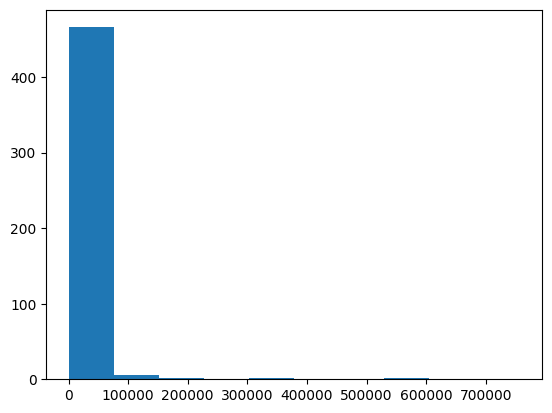

In [25]:
# @title Histrogams of Sales

plt.figure()
plt.hist(data=df,x='sales')
plt.show()

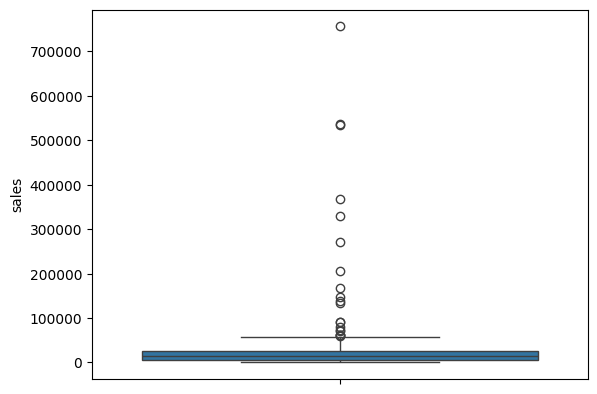

In [26]:
# @title Boxplot of Sales

plt.figure()
sns.boxplot(data=df['sales'])
plt.show()

In [27]:
# @title Correlation Analysis
df.select_dtypes(include='number').corr()

,sales,no_of_products
sales,1.000000,0.402449
no_of_products,0.402449,1.000000


In [28]:
#df.reset_index(inplace=True)
df.head()

,month,customer,sales,no_of_products
424,2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26
750,2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27
751,2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28
745,2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14
752,2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14


## Apply Log Tranformation to eliminate outliers

In [29]:

# Log transform sales_amount
df['sales_log'] = df['sales'].apply(lambda x: np.log(x) if x > 0 else np.nan)


In [30]:
# Drop rows with NaN in target
df = df.dropna(subset=['sales_log'])

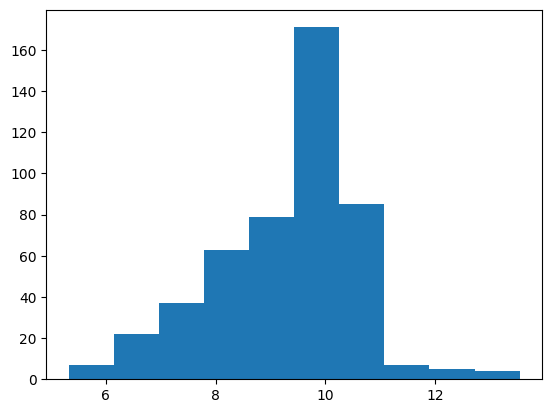

In [31]:
# @title Histrogams of Sales after applying Log Transformation

plt.figure()
plt.hist(data=df,x='sales_log')
plt.show()

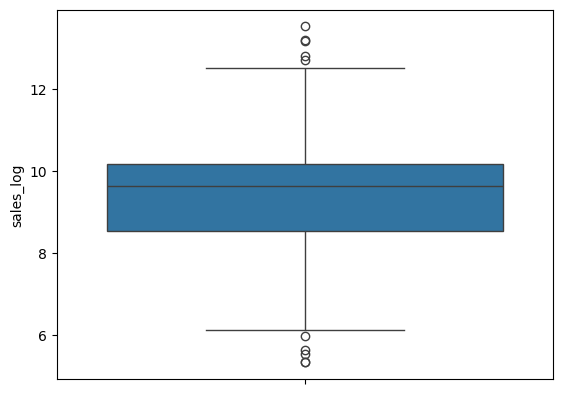

In [32]:
# @title Boxplot of Sales after Log Transformation

plt.figure()
sns.boxplot(data=df['sales_log'])
plt.show()

In [33]:
# @title Correlation Analysis afer Log Transform
df.select_dtypes(include='number').corr()

,sales,no_of_products,sales_log
sales,1.000000,0.402449,0.546670
no_of_products,0.402449,1.000000,0.577874
sales_log,0.546670,0.577874,1.000000


In [34]:
# Creating funciton to add Time Series Features in given Data Frame
def add_time_series_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df.reset_index(inplace=True)
    #df['year_month'] = df['date'].dt.to_period('M')
    #df['year_month'] = df['date'].dt.to_timestamp()
    #df['year'] = df['date'].dt.year
    #df['month'] = df['month'].dt.month
    #df['quarter'] = df['date'].dt.quarter
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    df.set_index('month', inplace=True)
    df.drop('index',axis=1,inplace=True)
    #X = df[['dayofweek','quarter','month','year',
           #'dayofyear','dayofmonth']]
    #if label:
     #   y = df[label]
      #  return X, y
    return df

In [35]:
# Adding Time Series Features in data frame
df = add_time_series_features(df,None)

In [36]:
df.head(25)

,customer,sales,no_of_products,sales_log
month,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181
2024-06-01,AFFORD A CARE PET HOSPITAL,15422.25,11,9.643567
2024-07-01,AFFORD A CARE PET HOSPITAL,30001.00,17,10.308986
2024-08-01,AFFORD A CARE PET HOSPITAL,24805.00,17,10.118801
2024-09-01,AFFORD A CARE PET HOSPITAL,15151.50,14,9.625855


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2024-01-01 to 2024-12-01
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer        480 non-null    string 
 1   sales           480 non-null    float64
 2   no_of_products  480 non-null    int64  
 3   sales_log       480 non-null    float64
dtypes: float64(2), int64(1), string(1)
memory usage: 18.8 KB


In [38]:
def add_lag_features (df):
    df['lag_1'] = df.groupby('customer')['sales_log'].shift(1)
    df['lag_2'] = df.groupby('customer')['sales_log'].shift(2)
    #df['lag_3'] = df.groupby('customer')['sales'].shift(3)
    df['rolling_mean_2'] = df.groupby('customer')['sales_log'].rolling(window=2).mean().iloc[-1]
    return df

In [39]:
df = add_lag_features(df)

In [40]:
df.head(25)


,customer,sales,no_of_products,sales_log,lag_1,lag_2,rolling_mean_2
month,,,,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,NaN,NaN,10.119742
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,10.043858,NaN,10.119742
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,10.134570,10.043858,10.119742
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,10.553466,10.134570,10.119742
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,9.529884,10.553466,10.119742
2024-06-01,AFFORD A CARE PET HOSPITAL,15422.25,11,9.643567,9.851181,9.529884,10.119742
2024-07-01,AFFORD A CARE PET HOSPITAL,30001.00,17,10.308986,9.643567,9.851181,10.119742
2024-08-01,AFFORD A CARE PET HOSPITAL,24805.00,17,10.118801,10.308986,9.643567,10.119742
2024-09-01,AFFORD A CARE PET HOSPITAL,15151.50,14,9.625855,10.118801,10.308986,10.119742


In [41]:
df.count()

,0
customer,480
sales,480
no_of_products,480
sales_log,480
lag_1,440
lag_2,400
rolling_mean_2,480


# Train a model using XGBoost ML

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['customer_encoded'] = le.fit_transform(df['customer'])

In [43]:
df.head(25)

,customer,sales,no_of_products,sales_log,lag_1,lag_2,rolling_mean_2,customer_encoded
month,,,,,,,,
2024-01-01,AFFORD A CARE PET HOSPITAL,23014.00,26,10.043858,NaN,NaN,10.119742,0
2024-02-01,AFFORD A CARE PET HOSPITAL,25199.25,27,10.134570,10.043858,NaN,10.119742,0
2024-03-01,AFFORD A CARE PET HOSPITAL,38310.00,28,10.553466,10.134570,10.043858,10.119742,0
2024-04-01,AFFORD A CARE PET HOSPITAL,13765.00,14,9.529884,10.553466,10.134570,10.119742,0
2024-05-01,AFFORD A CARE PET HOSPITAL,18980.75,14,9.851181,9.529884,10.553466,10.119742,0
2024-06-01,AFFORD A CARE PET HOSPITAL,15422.25,11,9.643567,9.851181,9.529884,10.119742,0
2024-07-01,AFFORD A CARE PET HOSPITAL,30001.00,17,10.308986,9.643567,9.851181,10.119742,0
2024-08-01,AFFORD A CARE PET HOSPITAL,24805.00,17,10.118801,10.308986,9.643567,10.119742,0
2024-09-01,AFFORD A CARE PET HOSPITAL,15151.50,14,9.625855,10.118801,10.308986,10.119742,0


In [44]:
# split train and test data from df
split_date = '2024-09-01'
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [45]:
x_train = train_df.drop(columns=['sales','sales_log','customer'])
y_train = train_df['sales_log']
x_test = test_df.drop(columns=['sales','sales_log','customer'])
y_test = test_df['sales_log']

In [46]:
x_train.head()


,no_of_products,lag_1,lag_2,rolling_mean_2,customer_encoded
month,,,,,
2024-01-01,26,NaN,NaN,10.119742,0
2024-02-01,27,10.043858,NaN,10.119742,0
2024-03-01,28,10.134570,10.043858,10.119742,0
2024-04-01,14,10.553466,10.134570,10.119742,0
2024-05-01,14,9.529884,10.553466,10.119742,0


In [47]:
y_train.head()

,sales_log
month,
2024-01-01,10.043858
2024-02-01,10.134570
2024-03-01,10.553466
2024-04-01,9.529884
2024-05-01,9.851181


In [48]:
x_test.head()

,no_of_products,lag_1,lag_2,rolling_mean_2,customer_encoded
month,,,,,
2024-10-01,17,9.625855,10.118801,10.119742,0
2024-11-01,8,10.240404,9.625855,10.119742,0
2024-12-01,5,8.966771,10.240404,10.119742,0
2024-10-01,47,10.391564,10.559213,10.119742,1
2024-11-01,39,10.419953,10.391564,10.119742,1


In [49]:
print(y_test.head())

month
2024-10-01    10.240404
2024-11-01     8.966771
2024-12-01     8.748345
2024-10-01    10.419953
2024-11-01    10.298050
Name: sales_log, dtype: float64


### Feature Importances
<p> Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of week was most commonly used to split trees, while day of the month and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits. <p>

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]

}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(eval_metric="mae"),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error', # Use negative MAE for optimization
                           cv=3, # Cross-validation folds
                           verbose=2,
                           n_jobs=-1
                           ) # Use all available cores

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best negative MAE found: ", grid_search.best_score_)

# Update the regressor with the best parameters
reg_tuned = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [ ]:
_ = plot_importance(reg_tuned, height=0.9)

In [ ]:
test_df['sales_prediction'] = reg_tuned.predict(x_test)
df_all = pd.concat([test_df,train_df], sort=False)

In [ ]:
test_df['sales_prediction_org_scale'] = np.exp(test_df['sales_prediction'])

In [ ]:
#test_df.head(25)

In [ ]:
df_10000863 = test_df[test_df['customer'] == 'AFFORD A CARE PET HOSPITAL']

df_10000863[['customer','sales','sales_prediction_org_scale']]

In [ ]:
test_df[['customer','sales','sales_prediction_org_scale']].head(30)

In [ ]:
_ = df_all[['sales','sales_prediction']].plot(figsize=(15, 5))
#plt.title('Sales and Tuned Model Predictions Over Time')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

In [ ]:

# Train the model
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(x_train, y_train)

In [ ]:
# Predict future sales
predictions = model.predict(x_test)

In [ ]:
# Evaluate performance of log_sales
mae = mean_absolute_error(np.exp(y_test), np.exp(predictions))
rmse = mean_squared_error(np.exp(y_test), np.exp(predictions))
r2 = r2_score(np.exp(y_test), np.exp(predictions))

print(f"Log Mean Absolute Error (MAE): {mae:.2f}")
print(f"Log Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Log R-squared (R²): {r2:.2f}")

# Bias and variance
bias_squared = (np.mean(predictions) - np.mean(y_test)) ** 2
variance = np.var(predictions)
mse = mean_squared_error(y_test, predictions)


# Print results
print(f"Bias²: {bias_squared:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

In [ ]:
plot_importance(model)

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', marker='o')
plt.plot(y_test.index, predictions, label='Predicted Sales', marker='x')
#plt.title('Actual vs Predicted Sales')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# Plot distributions
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(predictions, label='Predicted', fill=True)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Target Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Plot histogram comparison
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.6, label='Actual Values', color='blue', edgecolor='black')
plt.hist(predictions, bins=30, alpha=0.6, label='Predicted Values', color='orange', edgecolor='black')
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Here’s how to interpret your model’s performance metrics:

##### 1. Log Mean Absolute Error (MAE): 7246.12

This is the average absolute difference between your model’s predicted sales (after reversing the log transform) and the actual sales.
On average, your predictions are off by about 7,246 units of sales.
Lower is better; compare this to the typical sales value to judge if it’s acceptable.

##### 2. Log Root Mean Squared Error (RMSE): 208,247,409.04

This is the square root of the average squared difference between predicted and actual sales (after reversing the log).
It penalizes large errors more than MAE.
The very large value suggests there are some big outliers or errors in your predictions.

##### 3. Log R-squared (R²): 0.41

R² measures how much of the variance in the actual sales your model explains.
0.41 means your model explains 41% of the variation in sales.
Closer to 1 is better; 0.41 is moderate, so there’s room for improvement.
##### 4. Bias²: 0.01

This measures how far the average prediction is from the average actual value (on the log scale).
0.01 is very low, so your model is not systematically over- or under-predicting.
##### 5. Variance: 1.20

This is the variance of your predictions (on the log scale).
It shows how much your predictions vary. High variance can mean overfitting, but 1.20 is not extreme.

##### 6. Mean Squared Error (MSE): 0.30

This is the average squared difference between predicted and actual values (on the log scale).
Lower is better; it’s a standard regression loss metric.
##### Summary:

1. Your model is moderately good (R² = 0.41), but the high RMSE suggests some large errors.
2. The average error (MAE) is 7,246 sales units, so check if this is acceptable for your business context.
3. Low bias means predictions are not systematically too high or low.
4. Consider improving the model by adding features, tuning hyperparameters, or handling outliers.
If you want to improve the model, focus on reducing RMSE and increasing R².